# Exercise 1: Kalman Filter on Motion Data

**Objective:** Apply the Kalman filter step by step to the dataset `Appendix 1 - xy_motion_kalman_filter_example.csv` and analyze convergence.

**Topics:**
- Initial state and covariance estimation
- Prediction and update steps
- Kalman gain calculation
- Effect of model and measurement variance
- Convergence analysis

**ECB-TI | Time Series Filtering and Frequency Domain Transformations**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos de movimiento sin encabezado
motion_df = pd.read_csv('Appendix 1 - xy_motion_kalman_filter_example.csv', header=None)
motion_df.head()

,0,1
0,2.35,1.45
1,3.55,1.80
2,3.00,2.90
3,2.65,4.20
4,2.95,5.15


In [3]:
# Asignar encabezado a las columnas
motion_df.columns = ['x', 'y']
motion_df.head()

,x,y
0,2.35,1.45
1,3.55,1.80
2,3.00,2.90
3,2.65,4.20
4,2.95,5.15


In [4]:
# Inicialización del filtro de Kalman
x = np.array([[motion_df['x'][0]], [0]])  # posición inicial y velocidad inicial
P = np.array([[1, 0], [0, 1]])
print('Estado inicial:', x.flatten())
print('Covarianza inicial:', P)

Estado inicial: [2.35 0.  ]
Covarianza inicial: [[1 0]
 [0 1]]


### ¿Cómo se estiman los valores de las covarianzas Q y R?

- **Covarianza del proceso (Q):** Representa la incertidumbre o el ruido del modelo. Se puede estimar a partir del conocimiento del sistema físico, pruebas experimentales, o ajustando el valor para que el filtro responda adecuadamente a cambios inesperados. En la práctica, se suele probar diferentes valores y observar el comportamiento del filtro: un Q alto hace que el filtro confíe menos en el modelo y más en las mediciones.


- **Covarianza de la observación (R):** Representa la incertidumbre o el ruido de las mediciones. Se puede estimar calculando la varianza de los errores de medición (por ejemplo, midiendo varias veces el mismo valor y calculando la varianza), o usando especificaciones del sensor. Un R alto hace que el filtro confíe menos en las mediciones y más en el modelo.


En resumen, los valores de Q y R se pueden ajustar empíricamente, mediante pruebas y análisis de la respuesta del filtro, o usando información estadística sobre el sistema y los sensores.

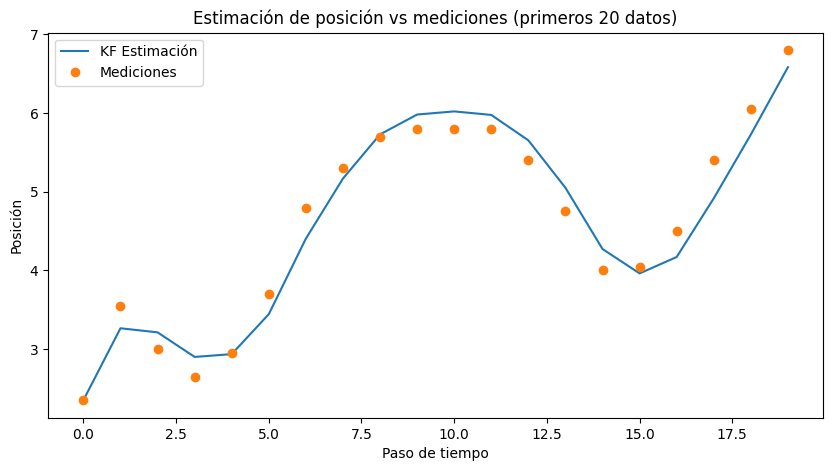

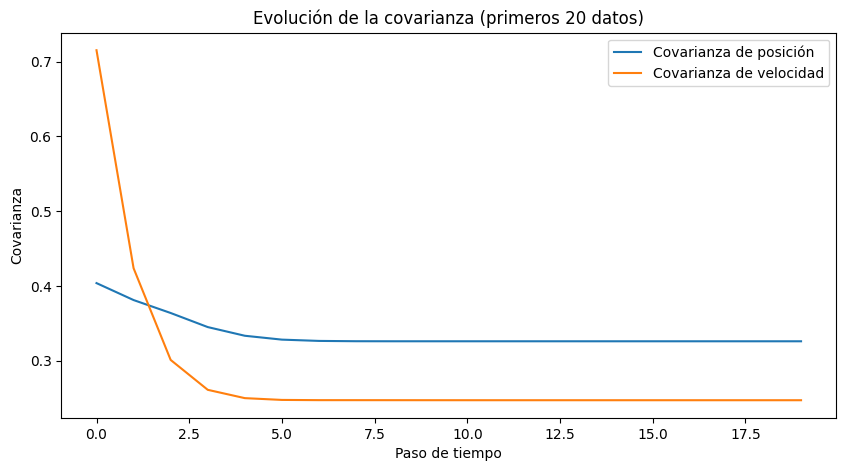

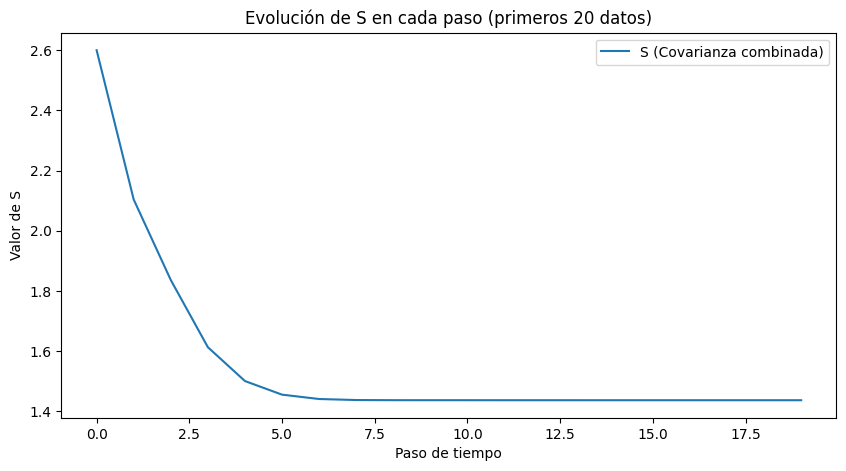

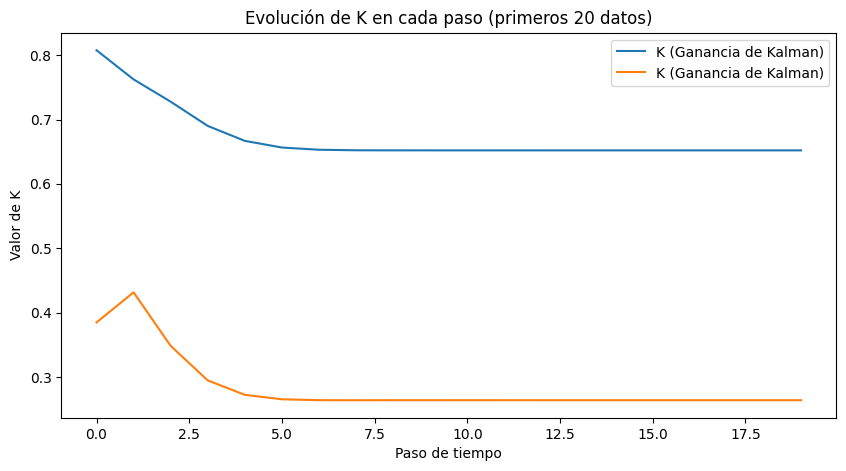

In [7]:
# Parámetros del filtro
F = np.array([[1, 1], [0, 1]])  # Matriz de transición de estado: predice el siguiente estado (posición y velocidad)
H = np.array([[1, 0]])        # Matriz de observación: extrae la posición del estado para comparar con la medición
Q = np.array([[0.1, 0], [0, 0.1]])  # Covarianza del proceso: incertidumbre del modelo (ruido del sistema)
R = np.array([[0.5]])               # Covarianza de la observación: incertidumbre de la medición (ruido del sensor)

n_steps = 20  # Solo los primeros 20 datos
x_hist = []
P_hist = []
z_hist = []
S_hist = []
K_hist = []

x_k = x.copy()
P_k = P.copy()
for k in range(n_steps):
    # 1. Predicción del estado siguiente usando el modelo
    x_pred = F @ x_k  # Estado predicho: posición y velocidad para el siguiente paso
    # 2. Predicción de la covarianza del estado
    P_pred = F @ P_k @ F.T + Q  # Covarianza predicha: incertidumbre del estado predicho
    # 3. Medición real en este paso
    z = np.array([[motion_df['x'][k]]])  # Observación de la posición en el paso k
    # 4. Cálculo de la ganancia de Kalman
    S = H @ P_pred @ H.T + R  # Covarianza combinada de predicción y medición
    #Ganancia alta (cercana a 1): Indica que se tiene alta confianza en la medición y baja confianza en la predicción. Esto significa que el sistema actualizará su estimación considerablemente basándose en los nuevos datos (la medición). 
    #Ganancia baja (cercana a 0): Indica que se tiene baja confianza en la medición y alta confianza en la predicción. El sistema hará un ajuste menor basándose en la nueva medición, ya que es considerada inexacta. 
    K = P_pred @ H.T @ np.linalg.inv(S)  # Ganancia de Kalman: cuánto confiar en la medición vs el modelo
    # Guardar S y K para graficar
    S_hist.append(S.flatten())
    K_hist.append(K.flatten())
    # 5. Actualización del estado con la medición
    x_k = x_pred + K @ (z - H @ x_pred)  # Estado corregido: combina predicción y medición
    # 6. Actualización de la covarianza del estado
    P_k = (np.eye(2) - K @ H) @ P_pred  # Covarianza corregida: reduce incertidumbre tras la medición
    # 7. Guardar resultados para graficar
    x_hist.append(x_k.flatten())  # Estado estimado
    P_hist.append(np.diag(P_k))   # Covarianza estimada
    z_hist.append(z.flatten())    # Medición real
x_hist = np.array(x_hist)
P_hist = np.array(P_hist)
z_hist = np.array(z_hist)
S_hist = np.array(S_hist)
K_hist = np.array(K_hist)

# Graficar estimación y mediciones
plt.figure(figsize=(10,5))
plt.plot(x_hist[:,0], label='KF Estimación')
plt.plot(motion_df['x'].values[:n_steps], 'o', label='Mediciones')
plt.xlabel('Paso de tiempo')
plt.ylabel('Posición')
plt.title('Estimación de posición vs mediciones (primeros 20 datos)')
plt.legend()
plt.show()

# Graficar evolución de la covarianza
plt.figure(figsize=(10,5))
plt.plot(P_hist[:,0], label='Covarianza de posición')
plt.plot(P_hist[:,1], label='Covarianza de velocidad')
plt.xlabel('Paso de tiempo')
plt.ylabel('Covarianza')
plt.title('Evolución de la covarianza (primeros 20 datos)')
plt.legend()
plt.show()

# Graficar evolución de S (covarianza combinada)
plt.figure(figsize=(10,5))
plt.plot(S_hist, label='S (Covarianza combinada)')
plt.xlabel('Paso de tiempo')
plt.ylabel('Valor de S')
plt.title('Evolución de S en cada paso (primeros 20 datos)')
plt.legend()
plt.show()

# Graficar evolución de K (ganancia de Kalman)
plt.figure(figsize=(10,5))
plt.plot(K_hist, label='K (Ganancia de Kalman)')
plt.xlabel('Paso de tiempo')
plt.ylabel('Valor de K')
plt.title('Evolución de K en cada paso (primeros 20 datos)')
plt.legend()
plt.show()

In [ ]:
# Parámetros del filtro
F = np.array([[1, 1], [0, 1]])  # Matriz de transición de estado: predice el siguiente estado (posición y velocidad)
H = np.array([[1, 0]])        # Matriz de observación: extrae la posición del estado para comparar con la medición
Q = np.array([[0.1, 0], [0, 0.1]])  # Covarianza del proceso: incertidumbre del modelo (ruido del sistema)
R = np.array([[0.5]])               # Covarianza de la observación: incertidumbre de la medición (ruido del sensor)

n_steps = len(motion_df)
x_hist = []
P_hist = []
z_hist = []
S_hist = []
K_hist = []

x_k = x.copy()
P_k = P.copy()
for k in range(n_steps):
    # 1. Predicción del estado siguiente usando el modelo
    x_pred = F @ x_k  # Estado predicho: posición y velocidad para el siguiente paso
    # 2. Predicción de la covarianza del estado
    P_pred = F @ P_k @ F.T + Q  # Covarianza predicha: incertidumbre del estado predicho
    # 3. Medición real en este paso
    z = np.array([[motion_df['x'][k]]])  # Observación de la posición en el paso k
    # 4. Cálculo de la ganancia de Kalman
    S = H @ P_pred @ H.T + R  # Covarianza combinada de predicción y medición
    #Ganancia alta (cercana a 1): Indica que se tiene alta confianza en la medición y baja confianza en la predicción. Esto significa que el sistema actualizará su estimación considerablemente basándose en los nuevos datos (la medición). 
    #Ganancia baja (cercana a 0): Indica que se tiene baja confianza en la medición y alta confianza en la predicción. El sistema hará un ajuste menor basándose en la nueva medición, ya que es considerada inexacta. 
    K = P_pred @ H.T @ np.linalg.inv(S)  # Ganancia de Kalman: cuánto confiar en la medición vs el modelo
    # Guardar S y K para graficar
    S_hist.append(S.flatten())
    K_hist.append(K.flatten())
    # 5. Actualización del estado con la medición
    x_k = x_pred + K @ (z - H @ x_pred)  # Estado corregido: combina predicción y medición
    # 6. Actualización de la covarianza del estado
    P_k = (np.eye(2) - K @ H) @ P_pred  # Covarianza corregida: reduce incertidumbre tras la medición
    # 7. Guardar resultados para graficar
    x_hist.append(x_k.flatten())  # Estado estimado
    P_hist.append(np.diag(P_k))   # Covarianza estimada
    z_hist.append(z.flatten())    # Medición real
x_hist = np.array(x_hist)
P_hist = np.array(P_hist)
z_hist = np.array(z_hist)
S_hist = np.array(S_hist)
K_hist = np.array(K_hist)

# Graficar estimación y mediciones
plt.figure(figsize=(10,5))
plt.plot(x_hist[:,0], label='KF Estimación')
plt.plot(motion_df['x'].values, 'o', label='Mediciones')
plt.xlabel('Paso de tiempo')
plt.ylabel('Posición')
plt.title('Estimación de posición vs mediciones')
plt.legend()
plt.show()

# Graficar evolución de la covarianza
plt.figure(figsize=(10,5))
plt.plot(P_hist[:,0], label='Covarianza de posición')
plt.plot(P_hist[:,1], label='Covarianza de velocidad')
plt.xlabel('Paso de tiempo')
plt.ylabel('Covarianza')
plt.title('Evolución de la covarianza')
plt.legend()
plt.show()

# Graficar evolución de S (covarianza combinada)
plt.figure(figsize=(10,5))
plt.plot(S_hist, label='S (Covarianza combinada)')
plt.xlabel('Paso de tiempo')
plt.ylabel('Valor de S')
plt.title('Evolución de S en cada paso')
plt.legend()
plt.show()

# Graficar evolución de K (ganancia de Kalman)
plt.figure(figsize=(10,5))
plt.plot(K_hist, label='K (Ganancia de Kalman)')
plt.xlabel('Paso de tiempo')
plt.ylabel('Valor de K')
plt.title('Evolución de K en cada paso')
plt.legend()
plt.show()

### ¿Qué hace el operador @ en Python?

El operador `@` en Python realiza la multiplicación de matrices (producto matricial).

- Si tienes dos matrices `A` y `B`, entonces `A @ B` calcula el producto matricial estándar, es decir, suma de productos fila por columna.
- Es equivalente a `np.dot(A, B)` en NumPy, pero más legible y moderno.

En el filtro de Kalman, se usa para multiplicar matrices como la transición de estado, covarianzas y observaciones, siguiendo las reglas del álgebra lineal.

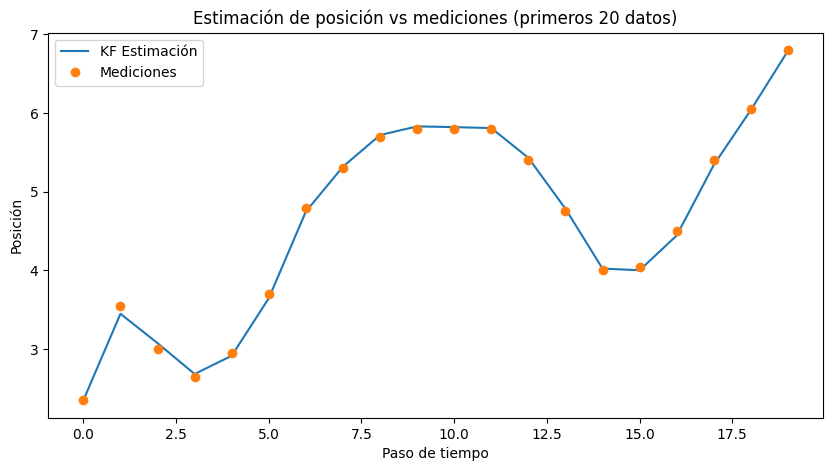

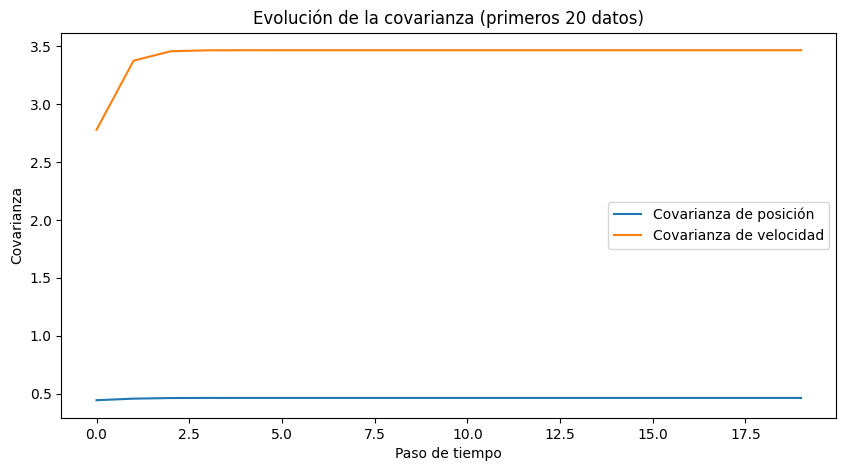

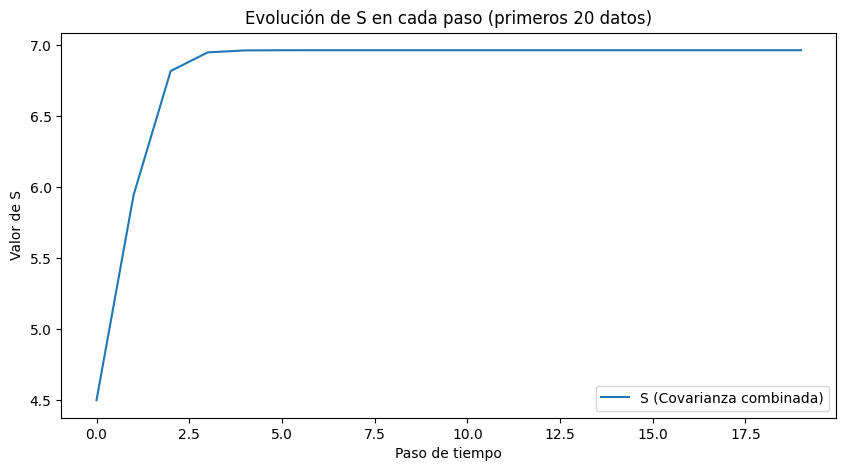

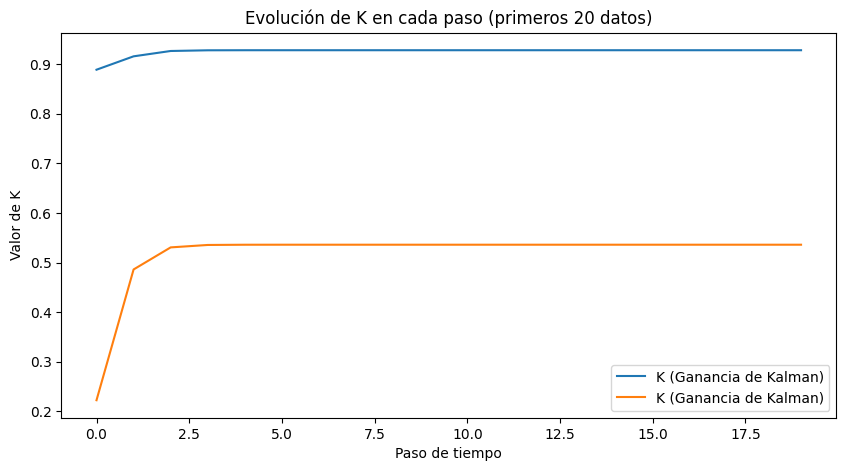

In [12]:
# Repetir con mayor varianza del modelo
# Q_new es una matriz de covarianza del proceso con valores más altos que la original Q. En el filtro de Kalman, la matriz Q representa la incertidumbre o el ruido del modelo (cuánto creemos que el sistema puede cambiar inesperadamente).
Q_new = np.array([[2.0, 0], [0, 2.0]])
# Parámetros del filtro
F = np.array([[1, 1], [0, 1]])  # Matriz de transición de estado: predice el siguiente estado (posición y velocidad)
H = np.array([[1, 0]])        # Matriz de observación: extrae la posición del estado para comparar con la medición
Q = Q_new  # Covarianza del proceso: incertidumbre del modelo (ruido del sistema)
R = np.array([[0.5]])               # Covarianza de la observación: incertidumbre de la medición (ruido del sensor)

n_steps = 20  # Solo los primeros 20 datos
x_hist = []
P_hist = []
z_hist = []
S_hist = []
K_hist = []

x_k = x.copy()
P_k = P.copy()
for k in range(n_steps):
    # 1. Predicción del estado siguiente usando el modelo
    x_pred = F @ x_k  # Estado predicho: posición y velocidad para el siguiente paso
    # 2. Predicción de la covarianza del estado
    P_pred = F @ P_k @ F.T + Q  # Covarianza predicha: incertidumbre del estado predicho
    # 3. Medición real en este paso
    z = np.array([[motion_df['x'][k]]])  # Observación de la posición en el paso k
    # 4. Cálculo de la ganancia de Kalman
    S = H @ P_pred @ H.T + R  # Covarianza combinada de predicción y medición
    #Ganancia alta (cercana a 1): Indica que se tiene alta confianza en la medición y baja confianza en la predicción. Esto significa que el sistema actualizará su estimación considerablemente basándose en los nuevos datos (la medición). 
    #Ganancia baja (cercana a 0): Indica que se tiene baja confianza en la medición y alta confianza en la predicción. El sistema hará un ajuste menor basándose en la nueva medición, ya que es considerada inexacta. 
    K = P_pred @ H.T @ np.linalg.inv(S)  # Ganancia de Kalman: cuánto confiar en la medición vs el modelo
    # Guardar S y K para graficar
    S_hist.append(S.flatten())
    K_hist.append(K.flatten())
    # 5. Actualización del estado con la medición
    x_k = x_pred + K @ (z - H @ x_pred)  # Estado corregido: combina predicción y medición
    # 6. Actualización de la covarianza del estado
    P_k = (np.eye(2) - K @ H) @ P_pred  # Covarianza corregida: reduce incertidumbre tras la medición
    # 7. Guardar resultados para graficar
    x_hist.append(x_k.flatten())  # Estado estimado
    P_hist.append(np.diag(P_k))   # Covarianza estimada
    z_hist.append(z.flatten())    # Medición real
x_hist = np.array(x_hist)
P_hist = np.array(P_hist)
z_hist = np.array(z_hist)
S_hist = np.array(S_hist)
K_hist = np.array(K_hist)

# Graficar estimación y mediciones
plt.figure(figsize=(10,5))
plt.plot(x_hist[:,0], label='KF Estimación')
plt.plot(motion_df['x'].values[:n_steps], 'o', label='Mediciones')
plt.xlabel('Paso de tiempo')
plt.ylabel('Posición')
plt.title('Estimación de posición vs mediciones (primeros 20 datos)')
plt.legend()
plt.show()

# Graficar evolución de la covarianza
plt.figure(figsize=(10,5))
plt.plot(P_hist[:,0], label='Covarianza de posición')
plt.plot(P_hist[:,1], label='Covarianza de velocidad')
plt.xlabel('Paso de tiempo')
plt.ylabel('Covarianza')
plt.title('Evolución de la covarianza (primeros 20 datos)')
plt.legend()
plt.show()

# Graficar evolución de S (covarianza combinada)
plt.figure(figsize=(10,5))
plt.plot(S_hist, label='S (Covarianza combinada)')
plt.xlabel('Paso de tiempo')
plt.ylabel('Valor de S')
plt.title('Evolución de S en cada paso (primeros 20 datos)')
plt.legend()
plt.show()

# Graficar evolución de K (ganancia de Kalman)
plt.figure(figsize=(10,5))
plt.plot(K_hist, label='K (Ganancia de Kalman)')
plt.xlabel('Paso de tiempo')
plt.ylabel('Valor de K')
plt.title('Evolución de K en cada paso (primeros 20 datos)')
plt.legend()
plt.show()

## ¿Converge la estimación del KF?

La estimación del filtro de Kalman tiende a estabilizarse y seguir las mediciones cuando la varianza del modelo es alta. Si la varianza del modelo es baja, el filtro confía más en el modelo y menos en las mediciones. La convergencia depende de la relación entre ambas varianzas. Observa los gráficos para ver cómo la estimación se ajusta a los datos reales y cómo la covarianza se estabiliza.